In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import initializers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

2022-02-10 16:35:31.035202: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-10 16:35:31.035257: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


<ErrorbarContainer object of 3 artists>

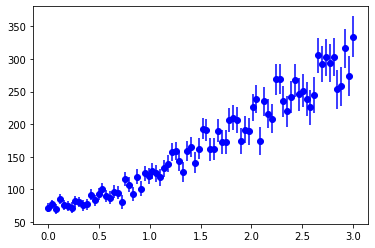

In [2]:
def Hub_the(z,om,H0):
    return H0*np.sqrt(om*pow(1+z,3)+1-om)


import scipy.integrate as integ

def normalized_hubble(z,args):
        om0 = args[1]
        omm = om0*pow(1.+z,3)
        ol0 = 1 - om0 

        return pow(omm + ol0 ,0.5)


def Ez_inv(z,args):
        return 1./normalized_hubble(z,args)


def com_dis(z,args):
        res = integ.quad(Ez_inv, 0., z, args=args)
        return res[0]


def mu_the(z,H0,om):
        mu = np.zeros(len(z))
        args = [H0,om]
        for i in range(len(z)):
                lsd = 3e5*(1+z[i])*com_dis(z[i],args)/H0
                mu[i] = 5*np.log10(lsd) + 25.
        return mu

def luminosity_distance(z,H0,om):
    dl = np.zeros(len(z))
    args = [H0,om]
    for i in range(len(z)):
        lsd = 3.e5*(1+z[i])*com_dis(z[i],args)/H0
        dl[i] = lsd
    return dl    


def xi2_lcdm(data,H0,om):
        y_obs = data[:,1]
        y_the = luminosity_distance(data[:,0],H0,om)
        y_err = data[:,2]
        x = (y_the - y_obs)/y_err
        return np.dot(x,x)


sig = 0.1
n_obs = 80
eps = np.random.normal(0.,sig,n_obs)
z_obs = np.linspace(0,3,n_obs)
H_obs = Hub_the(z_obs,0.3,70)*(1+eps)
dH_obs = Hub_the(z_obs,0.3,70)*sig

y_train = np.c_[H_obs,dH_obs]
plt.errorbar(z_obs,H_obs,yerr=dH_obs,fmt="bo")

In [3]:
h_data = np.genfromtxt("./data/hubel.dat")
z_obs = h_data[:,0]
y_train = h_data[:,1:]

SN data are loaded


<ErrorbarContainer object of 3 artists>

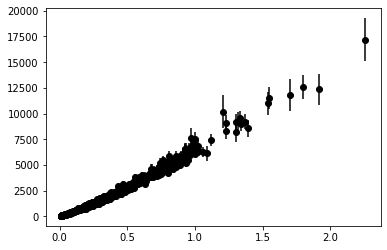

In [4]:
from pathlib import Path
import os
cwd=os.getcwd()

path_cov = cwd + '/data/cov_full.txt'
path_lcp = cwd + '/data/Tdata.txt'

cov_file = Path(path_cov)
lcp_file = Path(path_lcp)

if cov_file.is_file() and lcp_file.is_file():
    cov = np.genfromtxt(path_cov)
    lcp = np.genfromtxt(path_lcp)
                
    z_obs = lcp[:,1]
    mu_obs = lcp[:,4] + 19.3

    cov_mat_sys = np.reshape(cov,(1048,1048))
    cov_mat_sta = np.zeros((1048,1048))
    
    
    for i in range(len(lcp)):
        cov_mat_sys[i][i] = cov_mat_sys[i][i] + pow(lcp[i,5],2)
        cov_mat_sta[i][i] = cov_mat_sta[i][i] + pow(lcp[i,5],2)
        
    cov_mat_sys_inv = np.linalg.inv(cov_mat_sys)
    cov_mat_sta_inv = np.linalg.inv(cov_mat_sta)           
    print("SN data are loaded")   
    
else:
    print("SN files do not exist")
    sys.exit(0) 

dmu_obs = np.sqrt(cov_mat_sys.diagonal())
data = np.c_[z_obs,mu_obs,dmu_obs]
data.view('f8,f8,f8').sort(order=['f0'], axis=0)

z_obs = data[:,0]
mu_obs = data[:,1]
dmu_obs = data[:,2]

#dmu_obs = np.sqrt(cov_mat_sys.diagonal())

def convert_to_Dl(mu,dmu):
    dl = pow(10,(mu-25)/5)
    sig_dl = dmu*dl*0.4605
    return dl,sig_dl

  
Dl_obs , dDl_obs = convert_to_Dl(mu_obs,dmu_obs)

y_train = np.c_[Dl_obs/1e4 , dDl_obs/1e4]


plt.errorbar(z_obs,Dl_obs,yerr=dDl_obs,fmt='o',lw=1,elinewidth=1.5,color="black")

In [14]:
inputs = tf.keras.Input(shape=(1,))

x = Dense(4050, activation='elu',name='l1')(inputs)
#x = Dense(20, activation='elu',name='l2')(x)
#x = Dense(10, activation='elu',name='l3')(x)
outputs = Dense(2,name="last")(x)
model1 = tf.keras.Model(inputs=inputs, outputs=outputs)

loss_fn = tf.keras.losses.mean_squared_error
#loss_fn = tf.keras.losses.mean_absolute_error
model1.compile(optimizer='Adam',loss=loss_fn)
model1.fit(z_obs.reshape(-1,1),y_train,epochs=500,verbose=1)

Epoch 1/500
33/33 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 2/500
33/33 [==============================] - 0s 3ms/step - loss: 4.2711e-04
Epoch 3/500
33/33 [==============================] - 0s 3ms/step - loss: 5.2514e-04
Epoch 4/500
33/33 [==============================] - 0s 3ms/step - loss: 4.5736e-04
Epoch 5/500
33/33 [==============================] - 0s 3ms/step - loss: 4.8617e-04
Epoch 6/500
33/33 [==============================] - 0s 3ms/step - loss: 4.6962e-04
Epoch 7/500
33/33 [==============================] - 0s 3ms/step - loss: 5.2916e-04
Epoch 8/500
33/33 [==============================] - 0s 3ms/step - loss: 5.7309e-04
Epoch 9/500
33/33 [==============================] - 0s 4ms/step - loss: 5.0074e-04
Epoch 10/500
33/33 [==============================] - 0s 3ms/step - loss: 5.3276e-04
Epoch 11/500
33/33 [==============================] - 0s 4ms/step - loss: 5.2605e-04
Epoch 12/500
33/33 [==============================] - 0s 3ms/step - loss: 4.99

In [15]:
inputs = tf.keras.Input(shape=(1,))

x = Dense(10, activation='selu',name='l1')(inputs)
x = Dense(20, activation='selu',name='l2')(x)
x = Dense(20, activation='selu',name='l3')(x)
x = Dense(10, activation='selu',name='l4')(x)
outputs = Dense(2,name="last")(x)
model2 = tf.keras.Model(inputs=inputs, outputs=outputs)

loss_fn = tf.keras.losses.mean_squared_error
#loss_fn = tf.keras.losses.mean_absolute_error
model2.compile(optimizer='Adam',loss=loss_fn)
model2.fit(z_obs.reshape(-1,1),y_train,epochs=200,verbose=1)

Epoch 1/200
33/33 [==============================] - 0s 1ms/step - loss: 0.0219
Epoch 2/200
33/33 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 3/200
33/33 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 4/200
33/33 [==============================] - 0s 1ms/step - loss: 9.4189e-04
Epoch 5/200
33/33 [==============================] - 0s 1ms/step - loss: 7.6126e-04
Epoch 6/200
33/33 [==============================] - 0s 2ms/step - loss: 6.2615e-04
Epoch 7/200
33/33 [==============================] - 0s 2ms/step - loss: 4.8658e-04
Epoch 8/200
33/33 [==============================] - 0s 2ms/step - loss: 4.3743e-04
Epoch 9/200
33/33 [==============================] - 0s 2ms/step - loss: 3.8470e-04
Epoch 10/200
33/33 [==============================] - 0s 2ms/step - loss: 3.5293e-04
Epoch 11/200
33/33 [==============================] - 0s 2ms/step - loss: 3.5894e-04
Epoch 12/200
33/33 [==============================] - 0s 2ms/step - loss: 2.8048e-04
E

In [16]:
y_pred1 = model1(z_obs.reshape(-1,1))
y_pred2 = model2(z_obs.reshape(-1,1))

x1 = (y_pred1[:,0]-y_train[:,0])/y_train[:,1]
xi2_1 = np.dot(x1,x1)

x2 = (y_pred2[:,0]-y_train[:,0])/y_train[:,1]
xi2_2 = np.dot(x2,x2)

print(xi2_1,xi2_2)

209415.69 30852.396


In [17]:
z_test = np.linspace(0,2.5,500)
y_test1 = model1(z_test.reshape(-1,1))
y_test2 = model2(z_test.reshape(-1,1))

y_upp1 = y_test1[:,0] + y_test1[:,1]
y_low1 = y_test1[:,0] - y_test1[:,1]

y_upp2 = y_test2[:,0] + y_test2[:,1]
y_low2 = y_test2[:,0] - y_test2[:,1]

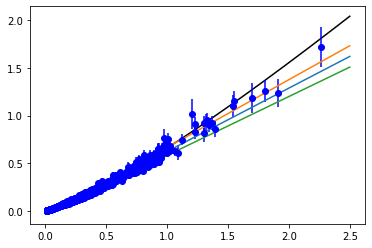

In [18]:
Dl_test = luminosity_distance(z_test,70,0.3)
plt.plot(z_test,Dl_test/1e4,color="k") 
plt.errorbar(z_obs,Dl_obs/1e4,yerr=dDl_obs/1e4,fmt="bo")
plt.plot(z_test,y_test1[:,0])
#plt.plot(z_test,y_test2[:,0])
plt.plot(z_test,y_upp1)
#plt.plot(z_test,y_upp2)
plt.plot(z_test,y_low1)
#plt.plot(z_test,y_low2)
#plt.xlim([0,2])

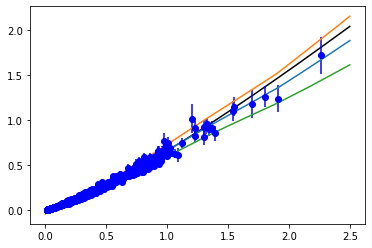

In [19]:
Dl_test = luminosity_distance(z_test,70,0.3)
plt.plot(z_test,Dl_test/1e4,color="k") 
plt.errorbar(z_obs,Dl_obs/1e4,yerr=dDl_obs/1e4,fmt="bo")
plt.plot(z_test,y_test2[:,0])
#plt.plot(z_test,y_test2[:,0])
plt.plot(z_test,y_upp2)
#plt.plot(z_test,y_upp2)
plt.plot(z_test,y_low2)
#plt.plot(z_test,y_low2)
#plt.xlim([0,2])

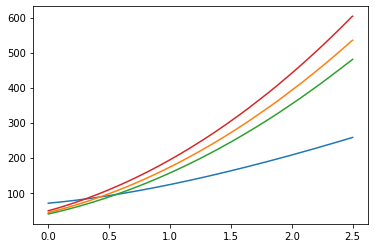

In [59]:
D_rec = y_test1[:,0]/(1+z_test)
D_rec_err = y_test1[:,1]/(1+z_test)

Dp_rec = np.gradient(D_rec,z_test[1]-z_test[0])
Dp_rec_upp = np.gradient(D_rec+D_rec_err,z_test[1]-z_test[0])
Dp_rec_low = np.gradient(D_rec-D_rec_err,z_test[1]-z_test[0])

H_t = Hub_the(z_test,0.3,70)

plt.plot(z_test,H_t)
plt.plot(z_test,3e1/Dp_rec)
plt.plot(z_test,3e1/Dp_rec_upp)
plt.plot(z_test,3e1/Dp_rec_low)

69.33210900667339


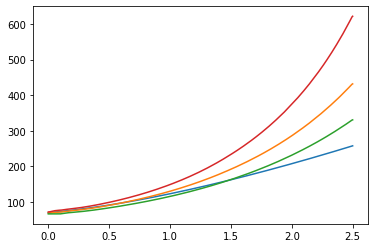

In [61]:
D_rec = y_test2[:,0]/(1+z_test)
D_rec_err = y_test2[:,1]/(1+z_test)

Dp_rec = np.gradient(D_rec,z_test[1]-z_test[0])
Dp_rec_upp = np.gradient(D_rec+D_rec_err,z_test[1]-z_test[0])
Dp_rec_low = np.gradient(D_rec-D_rec_err,z_test[1]-z_test[0])

plt.plot(z_test,H_t)
plt.plot(z_test,3e1/Dp_rec)
plt.plot(z_test,3e1/Dp_rec_upp)
plt.plot(z_test,3e1/Dp_rec_low)
print(3e1/Dp_rec[0])

In [65]:
data = h_data

y_err = tf.constant(data[:,2].reshape(-1,1),dtype=tf.float32)

def custom_loss(y_true, y_pred,sample_weight):
    diff = tf.square((y_pred - y_true)/sample_weight)
    return tf.math.reduce_sum(diff)

def my_loss_fn(y_true, y_pred):
    squared_difference = tf.square(y_true - y_pred)
    return tf.reduce_mean(squared_difference, axis=-1)     


inputs = tf.keras.Input(shape=(1,))

x = Dense(10, activation='selu',name='l1')(inputs)
x = Dense(20, activation='selu',name='l2')(x)
x = Dense(20, activation='selu',name='l3')(x)
x = Dense(10, activation='selu',name='l4')(x)
outputs = Dense(1,name="last")(x)
model3 = tf.keras.Model(inputs=inputs, outputs=outputs)

loss_fn = my_loss_fn
#loss_fn = custom_loss
#loss_fn = tf.keras.losses.mean_squared_error
#loss_fn = tf.keras.losses.mean_absolute_error
model3.compile(optimizer='Adam',loss=loss_fn,loss_weights=y_err)
hist = model3.fit(data[:,0].reshape(-1,1),data[:,1].reshape(-1,1),batch_size=39,epochs=100,verbose=0)

In [67]:
print(f"best loss = {hist.history['loss'][-1]}")

from keras import backend as K

y_pred = model3(data[:,0].reshape(-1,1))

x3 = (y_pred[:,0]-data[:,1])/data[:,2]


#x33  = K.dot(x3,x3)
xi2_3 = np.dot(x3,x3)

xx = custom_loss(y_pred,data[:,1].reshape(-1,1))

print(xi2_3,len(data[:,1]))

best loss = 141574.78125
tf.Tensor(
[-40.9096     -2.626259   -4.2541623  -1.9097023  -7.9325237 -13.8228245
 -10.984512   -1.783931   -3.9771192  -1.8391356  -4.3113956 -30.75474
  -4.4393344  -4.213956   -5.257979   -5.6588097  -7.52061    -5.3274603
  -6.269861   -1.1694444 -34.47485    -6.003046  -10.139888  -33.87187
  -8.125113   -9.962119   -6.4065433  -5.6414027  -1.5213429  -3.8110795
  -6.167904   -7.949346   -3.7693815  -7.9527035  -7.530509   -4.1486454
  -2.9586911 -26.075531  -23.303022 ], shape=(39,), dtype=float32)


TypeError: custom_loss() missing 1 required positional argument: 'sample_weight'

In [51]:
model = Sequential()
model.add(Dense(5,activation='tanh'))
#model.add(Dense(6,activation='tanh'))
model.add(Dense(5,activation='tanh'))
#model.add(Dense(6,activation='tanh'))
model.add(Dense(4,activation='tanh'))
model.add(Dense(1))
loss_fn = tf.keras.losses.mean_squared_error
model.compile(optimizer='Adam',loss=loss_fn)

hist = model.fit(x=data[:,0].reshape(-1,1),y=data[:,1].reshape(-1,1),epochs=100,verbose=0)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 5)                 10        
                                                                 
 dense_5 (Dense)             (None, 5)                 30        
                                                                 
 dense_6 (Dense)             (None, 4)                 24        
                                                                 
 dense_7 (Dense)             (None, 1)                 5         
                                                                 
Total params: 69
Trainable params: 69
Non-trainable params: 0
_________________________________________________________________


In [56]:
y_pred = model(data[:,0].reshape(-1,1))

x3 = (y_pred[:,0]-data[:,1])**2

xi2_3 = sum(x3)#np.dot(x3,x3)
print(xi2_3/39)

tf.Tensor(13367.099, shape=(), dtype=float32)


In [57]:
hist.history

{'loss': [13902.2900390625,
  13897.4873046875,
  13892.6357421875,
  13887.8681640625,
  13883.1923828125,
  13878.345703125,
  13873.6669921875,
  13868.9853515625,
  13864.357421875,
  13859.765625,
  13855.1494140625,
  13850.6455078125,
  13846.10546875,
  13841.7177734375,
  13837.21484375,
  13832.83984375,
  13828.5205078125,
  13823.9580078125,
  13819.810546875,
  13815.375,
  13811.044921875,
  13806.6572265625,
  13802.435546875,
  13798.1572265625,
  13793.740234375,
  13789.4228515625,
  13785.0869140625,
  13780.7548828125,
  13776.310546875,
  13771.91015625,
  13767.357421875,
  13762.939453125,
  13758.2607421875,
  13753.6826171875,
  13749.0732421875,
  13744.2705078125,
  13739.3173828125,
  13734.5595703125,
  13729.3896484375,
  13724.33984375,
  13718.9521484375,
  13713.7607421875,
  13708.052734375,
  13702.662109375,
  13696.9482421875,
  13691.1904296875,
  13685.302734375,
  13679.529296875,
  13673.6123046875,
  13667.3369140625,
  13661.529296875,
  13655